In [1]:
import scipy as sp
import numpy as np
import time
import multiprocessing 

from scipy.linalg import eigh, cholesky
from scipy.stats import norm

from pylab import plot, show, axis, subplot, xlabel, ylabel, grid

In [119]:
#x=sp.random.standard_normal(size=1000000)
#y=sp.random.standard_normal(size=1000000)
#z=sp.random.standard_normal(size=(100,100,100))
#mu, sigma = 0, 0.1 # mean and standard deviation
#abs(mu - np.mean(x)) < 0.01
#abs(sigma - np.std(x, ddof=1)) < 0.01
#x = norm.rvs(size=(num_streams, num_samples))

In [2]:
# Choice of cholesky or eigenvector method.
method = 'cholesky'
num_samples = 1000000
num_streams = 3
# The desired covariance matrix.
r = np.array([
        [  1, 0.75, 0.5],
        [ 0.75, 1, 0.75],
        [ 0.5, 0.75,  1]
    ])

In [3]:
# Generate samples from three independent normally distributed random variables (with mean 0 and std. dev. 1).

#generate 3 streams (A, B, C) of 1,000,000 independent random number 
#simulations following standard normal distribution

def getRandomNumberWithStandardNormalDistribution(num_streams,num_samples):
    return sp.random.standard_normal(size=(num_streams, num_samples))

ABC = getRandomNumberWithStandardNormalDistribution(num_streams, num_samples)

In [4]:
# We need a matrix `c` for which `c*c^T = r`.  We can use, for example,
# the Cholesky decomposition, or the we can construct `c` from the
# eigenvectors and eigenvalues.

def getCorrelatedRandomVariables(streams):   
    if method == 'cholesky':
        # Compute the Cholesky decomposition.
        c = cholesky(r, lower=True)
    else:
        # Compute the eigenvalues and eigenvectors.
        evals, evecs = eigh(r)
        # Construct c, so c*c^T = r.
        c = np.dot(evecs, np.diag(np.sqrt(evals)))
    return np.dot(c, streams)

# Convert the data to correlated random variables. 
y = getCorrelatedRandomVariables (ABC)

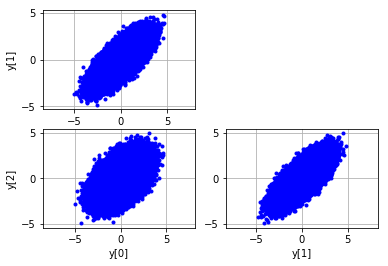

In [5]:
#
# Plot various projections of the samples.
#
subplot(2,2,1)
plot(y[0], y[1], 'b.')
#xlabel('y[0]')
ylabel('y[1]')
axis('equal')
grid(True)

subplot(2,2,3)
plot(y[0], y[2], 'b.')
xlabel('y[0]')
ylabel('y[2]')
axis('equal')
grid(True)

subplot(2,2,4)
plot(y[1], y[2], 'b.')
xlabel('y[1]')
#ylabel('y[2]')
axis('equal')
grid(True)

show()

In [7]:
#Define and set correlation of A (R_A) = 10%, R_B = 25%, R_C = 40%
R_A , R_B, R_C = 0.1, 0.25, 0.4
R_A_, R_B_, R_C_ = np.sqrt(1- R_A * R_A ),np.sqrt(1- R_B * R_B ),np.sqrt(1- R_C * R_C)


In [8]:
# For each simulation, define value of A (V_A) and calculate V_A = SQRT(1 - R_A**2) *
# Independent random number from (a) + R_A * Correlated random number 
# from (b) for the entire 1,000,000 simulations. Do the same for B and C. 
# [Check: Resultant array would be of the size of [3 columns x 1,000,000 rows]

V_A = np.dot(np.array([ R_A, R_A_]), np.array([y[0], ABC[0]]))
V_B = np.dot(np.array([ R_B, R_B_]), np.array([y[1], ABC[1]]))
V_C = np.dot(np.array([ R_C, R_C_]), np.array([y[2], ABC[2]]))

In [9]:
V_All = np.array([V_A,V_B, V_C])

In [10]:
#Define Probability of Default of A (PD_A) = 1%, PD_B = 10% and PD_C = 50%
PD_A,PD_B,PD_C =0.01, 0.1, 0.5
PD_ALL = np.array([PD_A,PD_B, PD_C])

In [11]:
#Calculate a default threshold using the formula for A, B and C. 
#Default threshold of A (DT_A) =  Inverse of standard normal cumulative distribution of (PD_A) 
# [Hint: Excel formula is NORMSINV(PD)]. Do the same for B and C.

import math

def rational_approximation(t):
    # Abramowitz and Stegun formula 26.2.23.
    # The absolute value of the error should be less than 4.5 e-4.
    c = [2.515517, 0.802853, 0.010328]
    d = [1.432788, 0.189269, 0.001308]
    numerator = (c[2]*t + c[1])*t + c[0]
    denominator = ((d[2]*t + d[1])*t + d[0])*t + 1.0
    return t - numerator / denominator

def normal_CDF_inverse(p):
    assert p > 0.0 and p < 1
    #  reference https://www.johndcook.com/blog/normal_cdf_inverse/.
    if p < 0.5:
        # F^-1(p) = - G^-1(p)
        return -rational_approximation( math.sqrt(-2.0*math.log(p)) )
    else:
        # F^-1(p) = G^-1(1-p)
        return rational_approximation( math.sqrt(-2.0*math.log(1.0-p)) )


In [13]:
DT_ALL = []
for i in range(len(PD_ALL)):
    DT_A = normal_CDF_inverse(PD_ALL[i])
    DT_ALL.append(DT_A)
DT_ALL

[-2.326785332558966, -1.281728756502709, -1.0100667546808495e-07]

In [14]:
# Define and set loss of A (L_A) = 0. In each simulation, if Value(V_A) < default threshold (DT_A),
# add a counter to loss. Calculate the loss for B(L_B) and C(L_C) separately. 
# Calculate the total loss (T) = (L_A + L_B + L_C).

start_time = time.time()
L_A, L_B, L_C = 0,0,0

def calculate_loss(V_A, DT_A, L_A):
    for i in range (len(V_A)):
        if V_A[i] < DT_A:
            L_A= L_A+1
    return L_A

L_A = calculate_loss (V_A, DT_ALL[0], L_A)
L_B = calculate_loss (V_B, DT_ALL[1], L_B)
L_C = calculate_loss (V_C, DT_ALL[2], L_C)
totalLoss = L_A+L_B+L_C
totalTime = (time.time() - start_time)

print("--- %s L_A ---" % L_A)
print("--- %s L_B ---" % L_B)
print("--- %s L_C ---" % L_C)

print("--- %s seconds ---" % totalTime)
print("--- %s totalLoss ---" % totalLoss)

--- 16623 L_A ---
--- 132106 L_B ---
--- 499917 L_C ---
--- 0.6999711990356445 seconds ---
--- 648646 totalLoss ---


In [17]:
def calculate_loss_parallel_chunk(V_A,  DT_A):
    loss =0
    for i in range (len(V_A)):
        if V_A[i] < DT_A:
            loss= loss+1
    return loss

def calculate_loss_parallel(V_A,  DT_A):
    pool = multiprocessing.Pool() 
    chunks =10
    parts = np.split(V_A, chunks)
    parallel_loss =0
    for part in parts:
        part_loss = pool.apply_async(calculate_loss_parallel_chunk, args = (part, DT_A ))
        parallel_loss = parallel_loss+ part_loss.get()
    return parallel_loss


In [19]:
def calculateTime_loss_parallel():
    start_time_parallel = time.time()
    for i in range(3):
        LossParallel= calculate_loss_parallel (V_All[i], DT_ALL[i])
        print (LossParallel)
    totalTime_parallel = (time.time() - start_time_parallel)
    return totalTime_parallel

calculateTime_loss_parallel()


0.8754019737243652